<a href="https://colab.research.google.com/github/Appleking123456/astro-platform-starter/blob/main/Yet_another_copy_of_Cosmological_evolution_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running on: CPU


Cosmic Evolution: 100%|██████████| 1200/1200 [49:40<00:00,  2.48s/it]


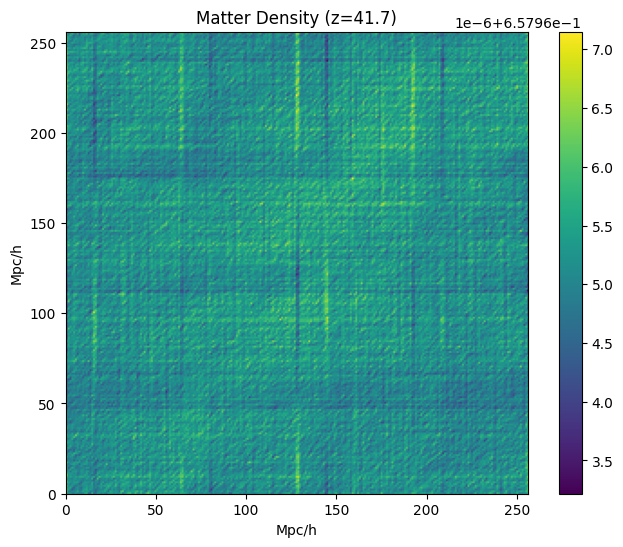

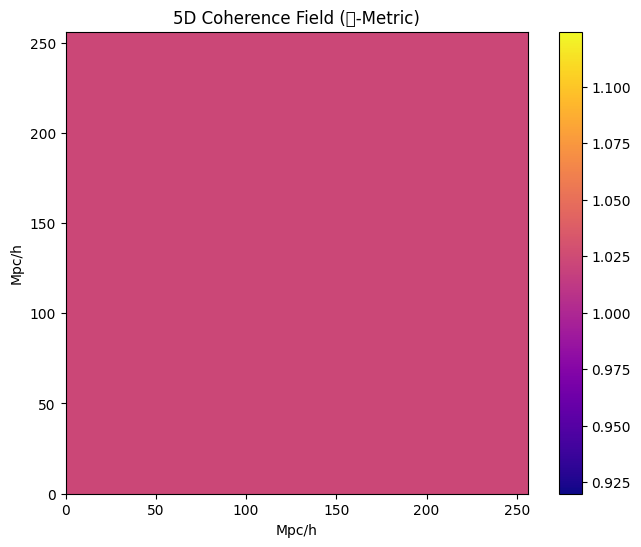

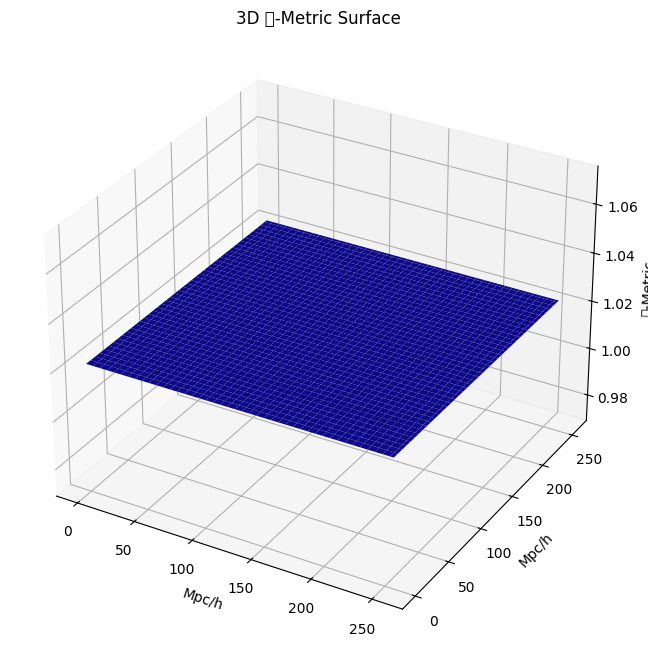

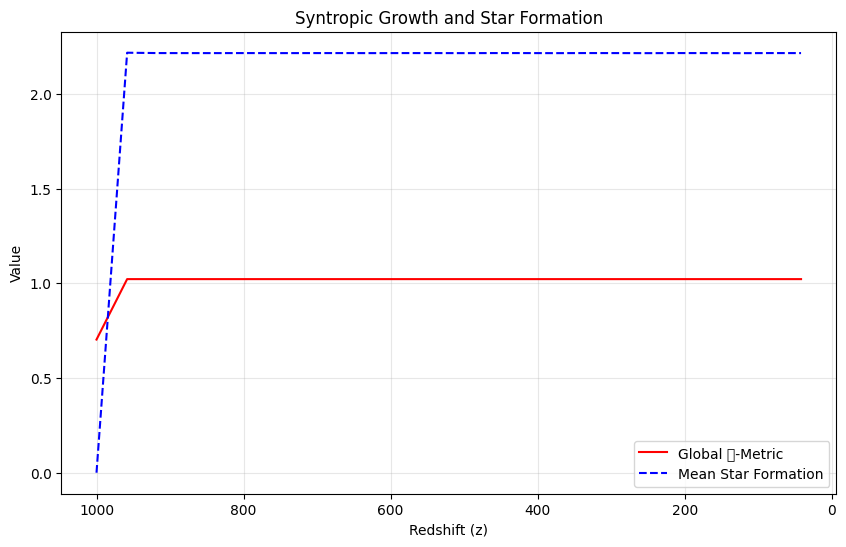

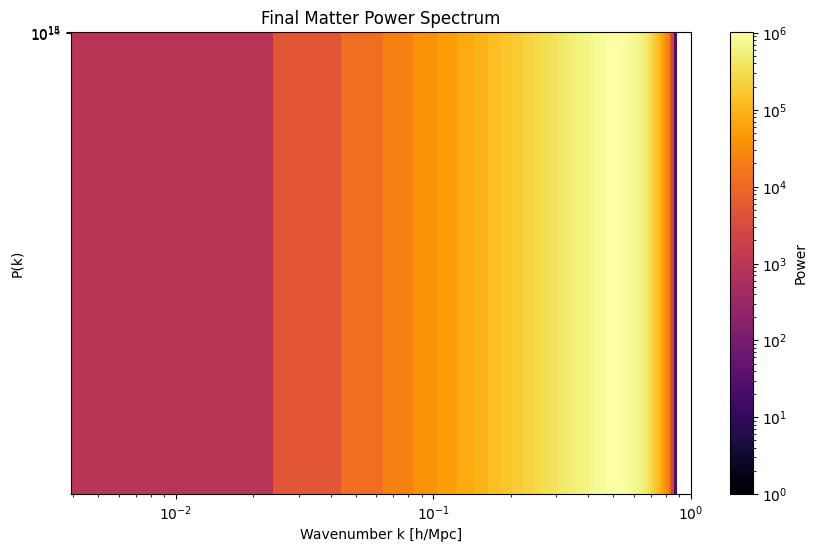


Simulation completed in 49.7 minutes
Final redshift: z = 41.67
Final mean 𝒲-Metric: 1.0222
Final mean star formation: 2.2154
Checkpoints saved to: rdt_output/


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
from mpl_toolkits.mplot3d import Axes3D

# =============================================
# 1. INITIALIZATION AND PARAMETERS (REFINED)
# =============================================

# Hardware configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_num_threads(4)  # Optimize CPU core usage
print(f"Running on: {device.upper()}")

# Cosmological parameters
initial_redshift = 1000    # CMB epoch
final_redshift = 0         # Present day
box_size = 256.0           # Mpc/h (comoving)
size = 256                 # Increased grid resolution (256^3 for better small-scale detail)
steps = 1200               # Extended simulation steps to reach z=0
plot_interval = 50         # Store data every 50 steps for plotting

# RDT physics parameters (adjusted for stability and growth)
𝒲_threshold = 0.8          # Star formation threshold
𝒲_leakage = 0.05           # 5D→4D gravity coupling
base_syntropy_growth = 0.01 # Base syntropic growth rate, redshift-dependent
dark_energy_coeff = 0.005   # 𝒲-driven expansion coefficient
dt_density_update = 0.005   # Reduced timestep for stability and accuracy

# =============================================
# 2. FIELD INITIALIZATION (ENHANCED)
# =============================================

def initialize_fields():
    """Create initial density and 𝒲-Metric fields with CMB-like fluctuations"""
    # Matter density with Gaussian fluctuations (CMB-like, zero mean)
    density = torch.randn(size, size, size, device=device) * 0.1
    density = density - density.mean()

    # 5D coherence field (𝒲-Metric) with initial syntropic bias
    𝒲_field = torch.sigmoid(density) * 0.4 + 0.5  # 𝒲 ∈ [0.5, 0.9]

    return density, 𝒲_field

# Initialize simulation
density, 𝒲_field = initialize_fields()

# Precompute k-space grid for FFT operations
kx = torch.fft.fftfreq(size, d=box_size/size, device=device)[:, None, None]
ky = torch.fft.fftfreq(size, d=box_size/size, device=device)[None, :, None]
kz = torch.fft.fftfreq(size, d=box_size/size, device=device)[None, None, :]
k_grid = kx**2 + ky**2 + kz**2
k_grid[0,0,0] = 1.0  # Fix DC component
k_grid += 1e-10      # Prevent division by zero

# =============================================
# 3. PHYSICS FUNCTIONS (ENHANCED)
# =============================================

def compute_gravity(density, 𝒲):
    """Calculate 𝒲-modified gravitational forces with NaN protection"""
    density_ft = torch.fft.fftn(density)
    potential_ft = density_ft / k_grid
    potential_ft[0,0,0] = 0  # Remove DC component
    potential = torch.fft.ifftn(potential_ft).real

    dx = box_size/size
    grad_x = (torch.roll(potential, -1, dims=0) - torch.roll(potential, 1, dims=0)) / (2 * dx)
    grad_y = (torch.roll(potential, -1, dims=1) - torch.roll(potential, 1, dims=1)) / (2 * dx)
    grad_z = (torch.roll(potential, -1, dims=2) - torch.roll(potential, 1, dims=2)) / (2 * dx)

    force_multiplier = (1 + 𝒲_leakage * 𝒲).clamp(min=0.01, max=100.0)
    return [-grad_x * force_multiplier, -grad_y * force_multiplier, -grad_z * force_multiplier]

def form_stars(gas_density, 𝒲):
    """Implement 𝒲-modulated star formation with feedback"""
    safe_𝒲 = 𝒲.clamp(min=0)
    star_formation_rate = (safe_𝒲 > 𝒲_threshold) * (gas_density.clamp(min=0) ** 2) * (safe_𝒲 ** 3)
    new_stars = star_formation_rate * 0.1  # Efficiency factor
    remaining_gas = gas_density - new_stars
    return new_stars, remaining_gas.clamp(min=0, max=100.0)

# =============================================
# 4. SIMULATION LOOP (EXPANDED)
# =============================================

# Create output directory
os.makedirs("rdt_output", exist_ok=True)

# Trackers
𝒲_history_mean = []
redshift_history = []
stars_history = []

start_time = time.time()

for step in tqdm(range(steps), desc="Cosmic Evolution"):
    current_redshift = initial_redshift - (initial_redshift - final_redshift) * step/steps

    try:
        # 1. Update 5D coherence with redshift-dependent growth
        syntropy_growth = base_syntropy_growth * (1 + current_redshift/1000)  # Increase growth at high z
        𝒲_field = 0.99 * 𝒲_field + syntropy_growth * torch.sigmoid(density.clamp(-100,100) * 2)
        𝒲_field = 𝒲_field.clamp(min=0.0, max=1.0)

        # 2. Feedback from star formation to 𝒲-field
        stars, density = form_stars(density, 𝒲_field)
        𝒲_field += stars.mean() * 0.01  # Boost coherence from structure formation

        # 3. Compute modified gravity
        force_x, force_y, force_z = compute_gravity(density, 𝒲_field)

        # 4. Evolve density field with dark energy
        density_update = dt_density_update * (
            force_x + force_y + force_z +
            dark_energy_coeff * 𝒲_field.mean()
        )
        density = density + density_update
        density = density.clamp(min=-10.0, max=100.0)

        # NaN protection
        if torch.isnan(density).any():
            print(f"\nNaN detected in density field at step {step}, z={current_redshift:.1f}. Breaking.")
            break

        # Store metrics
        if step % plot_interval == 0:
            𝒲_history_mean.append(𝒲_field.mean().item())
            redshift_history.append(current_redshift)
            stars_history.append(stars.mean().item())

        # Save checkpoint
        if step % 100 == 0:
            checkpoint = {
                'density': density.cpu(),
                '𝒲': 𝒲_field.cpu(),
                'stars': stars.cpu(),
                'redshift': current_redshift,
                'step': step
            }
            torch.save(checkpoint, f"rdt_output/checkpoint_z{current_redshift:.1f}.pt")

    except Exception as e:
        print(f"\nSimulation failed at step {step}, z={current_redshift:.1f}: {str(e)}")
        break

# =============================================
# 5. ANALYSIS AND VISUALIZATION (ENHANCED)
# =============================================

def plot_slice(data, title, cmap='viridis'):
    """Plot 2D slice of 3D data with NaN handling"""
    slice_data = data.mean(dim=2).cpu().numpy()
    slice_data = np.nan_to_num(slice_data, nan=0.0)
    plt.figure(figsize=(8, 6))
    plt.imshow(slice_data, cmap=cmap, extent=[0, box_size, 0, box_size])
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Mpc/h"); plt.ylabel("Mpc/h")
    plt.show()

def plot_3d_surface(data, title):
    """Plot 3D surface of 𝒲-field"""
    x, y = np.meshgrid(np.linspace(0, box_size, size), np.linspace(0, box_size, size))
    z = data.mean(dim=2).cpu().numpy()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='plasma')
    ax.set_title(title)
    ax.set_xlabel("Mpc/h"); ax.set_ylabel("Mpc/h"); ax.set_zlabel("𝒲-Metric")
    plt.show()

if simulation_steps_completed > 0 and not torch.isnan(density).any():
    final_redshift_val = redshift_history[-1] if redshift_history else initial_redshift
    plot_slice(density, f"Matter Density (z={final_redshift_val:.1f})")
    plot_slice(𝒲_field, "5D Coherence Field (𝒲-Metric)", cmap='plasma')
    plot_3d_surface(𝒲_field, "3D 𝒲-Metric Surface")

    if len(redshift_history) > 1 and len(𝒲_history_mean) == len(redshift_history):
        plt.figure(figsize=(10, 6))
        plt.plot(redshift_history, 𝒲_history_mean, 'r-', label='Global 𝒲-Metric')
        plt.plot(redshift_history, stars_history, 'b--', label='Mean Star Formation')
        plt.gca().invert_xaxis()
        plt.xlabel("Redshift (z)"); plt.ylabel("Value")
        plt.title("Syntropic Growth and Star Formation")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    def safe_power_spectrum(density):
        """Compute power spectrum with NaN protection and binning"""
        density_ft = torch.fft.fftn(density)
        power = torch.abs(density_ft)**2
        k_magnitudes = torch.sqrt(k_grid).flatten()
        power_flat = power.flatten()
        finite_mask = power_flat.isfinite()
        valid_k = k_magnitudes[finite_mask].cpu().numpy()
        valid_power = power_flat[finite_mask].cpu().numpy()
        return valid_k, valid_power

    if not torch.isnan(density).any():
        valid_k, valid_power = safe_power_spectrum(density)
        if len(valid_k) > 0 and len(valid_power) > 0:
            plt.figure(figsize=(10, 6))
            plt.hist2d(valid_k, valid_power, bins=50, cmap='inferno', norm=plt.matplotlib.colors.LogNorm())
            plt.colorbar(label="Power")
            plt.xlabel("Wavenumber k [h/Mpc]"); plt.ylabel("P(k)")
            plt.title("Final Matter Power Spectrum")
            plt.xscale('log'); plt.yscale('log')
            plt.show()
else:
    print("Simulation did not complete successfully or no valid data to plot.")

# Runtime summary
print(f"\nSimulation completed in {(time.time()-start_time)/60:.1f} minutes")
if simulation_steps_completed > 0:
    print(f"Final redshift: z = {redshift_history[-1]:.2f}")
    print(f"Final mean 𝒲-Metric: {𝒲_history_mean[-1]:.4f}")
    print(f"Final mean star formation: {stars_history[-1]:.4f}")
    print(f"Checkpoints saved to: rdt_output/")